In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = "../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

In [3]:
# Randomly sample.
def get_city_trajectories(city="palo-alto", split="train"):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs, dtype=float)

    return inputs, outputs

In [4]:
def get_all_city_trajectories(split="train"):
    X = None
    Y = None
    for city in cities:
        x, y = get_city_trajectories(city, split)
        if X is None:
            X = x
            Y = y
        else:
            X = np.concatenate([X, x], axis=0)
            if split=="train":
                Y = np.concatenate([Y, y], axis=0)
    return X, Y

In [5]:
def fitData(x, y, transform="MinMax"):
    if transform == 'MinMax':
        scaler = MinMaxScaler()
    elif transform == "Standard":
        scaler = StandardScaler()
    else:
        return x, y

    scaler.fit(x.reshape(-1, 2))
    scaler.fit(y.reshape(-1, 2))
    x_ = scaler.transform(x.reshape(-1, 2)).reshape(-1, 50, 2)
    y_ = scaler.transform(y.reshape(-1, 2)).reshape(-1, 60, 2)

    return x_, y_, scaler

In [6]:
def RMSE(pred, y):
    return np.linalg.norm(pred - y) / np.sqrt(len(pred))

In [7]:
def kFoldCV(x, y, scaler, k=5):
    best_loss = float('inf')
    best_model = None

    # Perform kFold validaiton split
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(x):
        # Split dataset into k folds
        X_train, X_test = x[train_index].reshape(-1, 100), x[test_index].reshape(-1, 100)
        y_train, y_test = y[train_index].reshape(-1, 120), y[test_index].reshape(-1, 2)

        # Fit training set
        reg = LinearRegression().fit(X_train, y_train)

        # Predict with validation
        pred = reg.predict(X_test).reshape(-1, 2)
        if scaler:
            pred = scaler.inverse_transform(pred)
            y_test_ = scaler.inverse_transform(y_test)

        # Get validation loss and find best model
        loss = RMSE(pred, y_test_)
        if loss < best_loss:
            best_loss = loss
            best_model = reg
        
        # Inverse transform prediction

    return best_model, best_loss

In [8]:
def bestModel(k=5):
    # fit and predict with linear regression
    x, y = get_all_city_trajectories()
    x_, y_, scaler = fitData(x, y, 'MinMax')

    # KFold: Get model with best validation
    model, score = kFoldCV(x_, y_, scaler, k)
    print('Best model loss:', score)

    # Predict
    x_test, _ = get_all_city_trajectories(split="test")
    test_pred = model.predict(x_test.reshape(-1, 50*2))
    return model

In [9]:
model = bestModel(5)

Best model loss: 6.5046314323424


In [14]:
def plot_path(input_true, output_true, output_pred, city=None):
    # Takes in input and output, dim=2
    xMin = min(min(input_true[:, 0]), min(output_true[:, 0]), min(output_true[:, 0]))
    xMax = max(max(input_true[:,0]), max(output_true[:, 0]), max(output_true[:, 0]))
    yMin = min(min(input_true[:,1]), min(output_true[:, 1]), min(output_true[:, 1]))
    yMax = max(max(input_true[:,1]), max(output_true[:, 1]), max(output_true[:, 1]))
    plt.figure(figsize=(10, 3))
    ax1 = plt.subplot(1, 3, 1)
    ax1.set_xlim(left=xMin, right=xMax)
    ax1.set_ylim(bottom=yMin, top=yMax)
    ax2 = plt.subplot(1, 3, 2, sharey=ax1, sharex=ax1)

    ax1.scatter(input_true[:, 0], input_true[:, 1])
    ax1.scatter(output_true[:, 0], output_true[:, 1], c='orange')
    ax1.set_title("True")
    ax2.scatter(input_true[:, 0], input_true[:, 1])
    ax2.scatter(output_pred[:, 0], output_pred[:, 1], c='orange')
    ax2.set_title("Prediction")
    
    if city is not None:
        plt.suptitle(city)

    plt.tight_layout()
    plt.show()

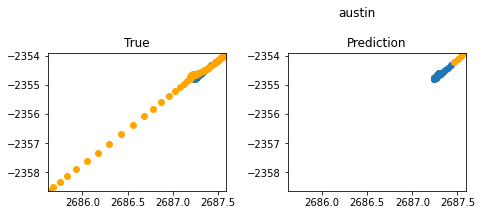

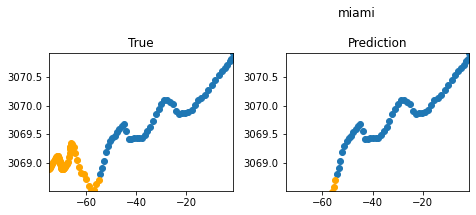

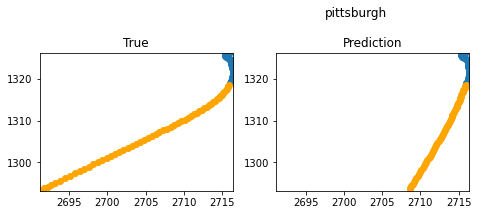

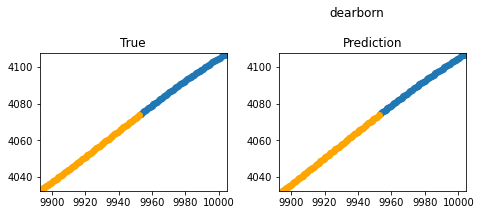

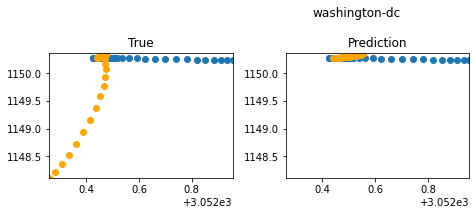

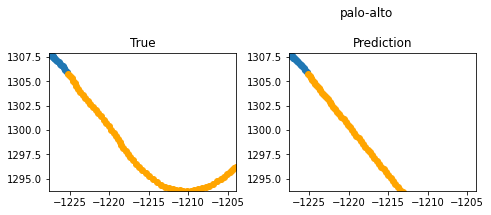

In [19]:
def plot_train_examples(model, n=1):
    for city in cities:
        '''
        x: (n, 50, 2)
        y: (n, 60, 2)
        pred: (n, 60, 2)
        '''
        x, y = get_city_trajectories(city)
        pred = model.predict(x.reshape(-1, 50*2)).reshape(-1, 60, 2)
        randidx = np.random.randint(len(x))
        plot_path(x[randidx], y[randidx], pred[randidx], city=city)

plot_train_examples(model)